# Báo cáo đồ án môn "Lập trình cho khoa học dữ liệu"

Thành viên:
1. 18120052 - Lê Hạnh Linh - linh0303052
2. 1712568 - Kim Đình Lộc - kimdinhloc

Link thùng chứa Github của nhóm: https://github.com/linh0303052/programming4DS

---

## Mô tả dữ liệu và bài toán 

Bộ dữ liệu về thông tin các chuyến taxi tại New York vào 6 tháng đầu năm 2016 dựa trên dữ liệu **[2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data)** có sẵn trên BigQuery của Google Cloud Platform. Dữ liệu gốc được phát hành bởi NYC *Taxi and Limousine Commission (TLC)* và có sẵn trên trang [NYC TLC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) . Tập dữ liệu đã được lấy mẫu (sample) và tiền xử lý dành cho cuộc thi **[New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview)** trên Kaggle.

Vì việc khám phá và tiền xử lý một tập dữ liệu bị ảnh hưởng bởi bài toán cần giải quyết trên tập dữ liệu đó nên nhóm chọn bài toán *New York City Taxi Trip Duration* để có cơ sở thực hiện khám phá và tiền xử lý hơn.

Cuộc thi *New York City Taxi Trip Duration* đặt ra bài toán dự đoán tổng thời gian của một chuyến taxi ở thành phố New York (Mỹ) dựa vào các thông tin như tọa độ điểm đón và trả khách, thời gian đón khách, số lượng hành khách.

**Input:** Dữ liệu gồm 9 thuộc tính của một chuyến taxi (id, vendor_id, pickup_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag) \
**Output:** Tổng thời gian dự đoán của chuyến đó tính bằng giây.

***Ghi chú***: Mặc dù tập test chỉ có 9 thuộc tính, tập train có 11 thuộc tính, trong đó 1 thuộc tính là target, còn lại 1 thuộc tính không có trong tập test là dropoff_datetime. Cuộc thi quyết định không loại cột này ra khỏi tập train để cung cấp tập mở rộng các biến và thí sinh sử dụng tùy ý trong quá trình làm việc.

---

## Import các thư viện cần thiết

In [81]:
# Bỏ comment để cài đặt thư viện folium
# !conda install -c conda-forge folium=0.5.0 --yes
# !pip install geopy

     |████████████████████████████████| 118 kB 366 kB/s            


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import geopy.distance

## Thu thập dữ liệu

---

## Khám phá dữ liệu

### Đọc dữ liệu từ file csv vào dataframe

In [175]:
taxi_df = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

In [14]:
num_rows = taxi_df.shape[0]
num_cols = taxi_df.shape[1]
print('{} dòng \n{} cột'.format(num_rows, num_cols))

1458644 dòng 
11 cột


### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Mỗi dòng là một bản ghi của một chuyến taxi. Các thuộc tính có ý nghĩa như ở phần mô tả. Theo quan sát không có dòng nào bất thường.

In [ ]:
temp_array = [tuple(row) for row in mvt_df]
uniques = np.unique(temp_array)
have_duplicated_rows = uniques.shape[0] == num_rows

### Dữ liệu có các dòng bị lặp không?

In [16]:
temp_array = [tuple(row) for row in taxi_df]
uniques = np.unique(temp_array)
have_duplicated_rows = uniques.shape[0] == num_rows
if have_duplicated_rows:
    print('Có dữ liệu trùng')
else:
    print('Không có dữ liệu trùng')

Không có dữ liệu trùng


In [ ]:
temp_array = [tuple(row) for row in mvt_df]
uniques = np.unique(temp_array)
have_duplicated_rows = uniques.shape[0] == num_rows

### Mỗi cột có ý nghĩa gì?

Tập dữ liệu huấn luyện đã xử lý gồm 11 cột, cột cuối cùng (trip_duration) là target: \
**id** - định danh duy nhất của mỗi chuyến \
**vendor_id** - mã của nhà cung cấp thông tin của mẫu này (vì thông tin không được thu thập và cung cấp bởi TLC mà được cung cấp bởi 2 nhà cung cấp khác nhau được đánh số là 1 và 2) \
**pickup_datetime** - ngày và giờ khi bắt đầu tính số mét \
**dropoff_datetime** - ngày và giờ khi kết thúc tính số mét \
**passenger_count** - số hành khách trên phương tiện (tài xế nhập thông tin này) \
**pickup_longitude** - kinh độ nơi bắt đầu tính số mét \
**pickup_latitude** - vĩ độ nơi bắt đầu tính số mét \
**dropoff_longitude** - kinh độ nơi kết thúc tính số mét \
**dropoff_latitude** - vĩ độ nơi kết thúc tính số mét \
**store_and_fwd_flag** - cờ đánh dấu 1 bản ghi có được ghi lại trong bộ nhớ của phương tiện trước khi được gửi đến cho nhà cung cấp không (điều này xảy ra vì phương tiện không có kết nối đến máy chủ khi di chuyển) \
**trip_duration** - thời gian của chuyến tính bằng giây

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [19]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Có 4 cột có kiểu dữ liệu object: *id, pickup_datetime, dropoff_datetime, store_and_fwd_flag*. Ta xem các kiểu dữ liệu có trong các cột này

In [20]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update((s.apply(lambda ele: type(ele)).to_numpy()))
    return dtypes

In [23]:
print(open_object_dtype(taxi_df['id']))
print(open_object_dtype(taxi_df['pickup_datetime']))
print(open_object_dtype(taxi_df['dropoff_datetime']))
print(open_object_dtype(taxi_df['store_and_fwd_flag']))

{<class 'str'>}
{<class 'str'>}
{<class 'str'>}
{<class 'str'>}


Tất cả các cột này đều dạng *str*. \
Cột *id* đơn giản là chuỗi định danh bản ghi nên ta có thể giữ nguyên. \
Cột *pickup_datetime* và *dropoff_datetime* ta cần chuyển sang kiểu *datetime* để thuận tiện tính toán và lấy ra các giá trị ngày, tháng, giờ sau này. \
Cột *store_and_fwd_flag* là cờ đánh dấu chuyến đó có store and forward cho nhà cung cấp không. Nên ta sẽ chuyển cột này thành kiểu *bool*. \

Ngoài ra, cột *vendor_id* tuy mang kiểu dữ liệu int64 dạng numeric, nhưng ý nghĩa của cột này là dạng categorical do cột này 

## Tiền xử lý

### Chuyển dtype của cột "pickup_datetime" và "dropoff_datetime" sang datetime

In [176]:
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

### Chuyển dtype của cột "store_and_fwd_flag" sang bool

In [177]:
taxi_df['store_and_fwd_flag'] = taxi_df['store_and_fwd_flag'].apply(lambda ele: False if ele == 'N' else True)

### Chuyển dtype của cột "vendor_id" sang str

In [178]:
taxi_df['vendor_id'] = taxi_df['vendor_id'].astype(str)

Kiểm tra lại các kiểu dữ liệu

In [67]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  object        
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  bool          
 10  trip_duration       1458644 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 112.7+ MB


Các cột *vendor_id*, *pickup_datetime*, *dropoff_datetime* và *store_and_fwd_flag* đã được chuyển về đúng kiểu dữ liệu mong muốn.

## Khám phá dữ liệu (tiếp tục)

### Với mỗi cột có kiểu dữ liệu dạng numeric, các giá trị được phân bố như thế nào?

Cột *vendor_id* có kiểu dữ liệu dạng numberic nhưng thực ra mang ý nghĩa là dạng categorical. Do 1 là từ nhà cung cấp 1 và 2 là nhà cung cấp 2. Nên ta sẽ khảo sát cột *vendor_id* ở phần sau.

In [124]:
nume_col_df = taxi_df[["passenger_count", "pickup_datetime", "dropoff_datetime","pickup_latitude", "pickup_longitude", "dropoff_latitude", \
                      "dropoff_longitude", "trip_duration"]]

In [125]:
def missing_ratio(s):
    return s.isna().mean() * 100

In [126]:
nume_col_df = nume_col_df.agg([missing_ratio, min, max]);
nume_col_df

,passenger_count,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_duration
missing_ratio,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
min,0.0,2016-01-01 00:00:17,2016-01-01 00:03:31,34.359695,-121.933342,32.181141,-121.933304,1.0
max,9.0,2016-06-30 23:59:39,2016-07-01 23:02:03,51.881084,-61.335529,43.921028,-61.335529,86392.0


May mắn, ta không có dữ liệu thiếu nào, có lẽ vì dữ liệu được ban tổ chức cuộc thi xử lý trước đó. \
Tuy nhiên nhìn vào min cột *passenger_count* có một chút bất thường do có chuyến mà không có người nào. Và 9 người cho một chuyến taxi thì hơi nhiều. \
min max của *trip_duration* cũng có một chút kỳ lạ, vì một chuyến chỉ đi dài 1s? Chuyến dài nhất dài 3526282s hơn 40 ngày?

#### Khảo sát cột "passenger_count"
Trước tiên xem phân bố và đếm số lượng các giá trị

Text(0, 0.5, 'count')

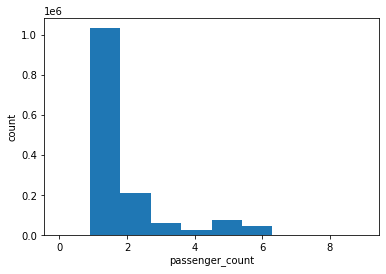

In [180]:
plt.hist(taxi_df['passenger_count'])
plt.xlabel('passenger_count')
plt.ylabel('count')

In [101]:
taxi_df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
8          1
9          1
Name: passenger_count, dtype: int64

Đa số các chuyến chỉ có 1 hoặc 2 hành khách. Các chuyến có 7, 8, 9 hành khách rất ít nên ta sẽ bỏ các dòng này. Có 60 chuyến có số hành khách là 0 có thể do lỗi nhập hoặc do tài xế nhập đại số 0 để hoàn thành việc nhập dữ liệu. Ta cũng sẽ loại các chuyến này.

#### Khảo sát cột "trip_duration"
Xem phân bố của trip_duration

In [121]:
taxi_df["trip_duration"].sort_values(ascending=False)[:10]

1234291    86392
295382     86391
73816      86390
59891      86387
1360439    86385
753765     86379
1221666    86378
91717      86378
66346      86377
1138915    86377
Name: trip_duration, dtype: int64

Có 4 chuyến có thời lượng dài bất thường. Ta sẽ loại các dòng này ra. Tuy nhiên, các dòng còn lại với thời gian khoảng 86300 giây là gần một ngày (một ngày dài 86400 giây). Ta sẽ xem thử phân bố của *trip_duration* ở khoảng từ 10-24 tiếng.

Text(0, 0.5, 'count')

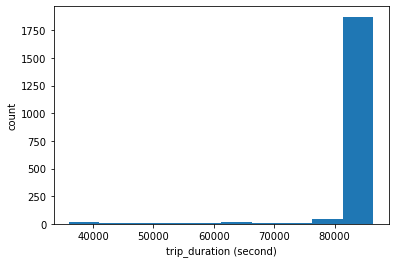

In [182]:
plt.hist(taxi_df['trip_duration'], range=(36000, 86400))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Khoảng từ 81360s đến 86400s có 1871 chuyến, nhiều bất thường nên ta sẽ bỏ các chuyến này. \
Ngoài các chuyến quá dài, cũng có những chuyến có khoảng thời gian rất ngắn. ta thử xem phân bố của các chuyến ít hơn 200s.

Text(0, 0.5, 'count')

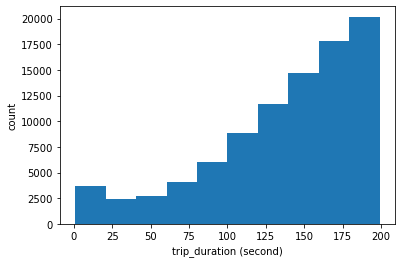

In [183]:
plt.hist(taxi_df[taxi_df["trip_duration"] < 200]['trip_duration'])
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Có 3616 chuyến ít hơn 20s. Ta thử tính khoảng cách giữa điểm đón và điểm nhận dựa vào tọa độ để xem mức độ hợp lý của các chuyến này.

Text(0, 0.5, 'count')

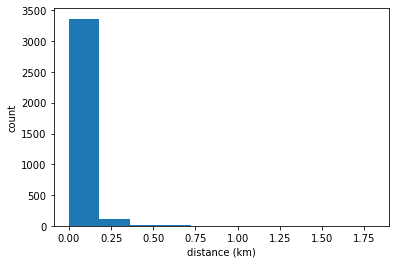

In [184]:
very_short_trips = taxi_df[taxi_df["trip_duration"] < 20]
pickup_coords = [(lat, lng) for lat, lng in zip(very_short_trips['pickup_latitude'], very_short_trips['pickup_longitude'])]
dropoff_coords = [(lat, lng) for lat, lng in zip(very_short_trips['dropoff_latitude'], very_short_trips['dropoff_longitude'])]
distances = [geopy.distance.distance(pu_coord, do_coord).km for pu_coord, do_coord in zip(pickup_coords, dropoff_coords)]
plt.hist(distances, range=(0, 1.80436312))
plt.xlabel('distance (km)')
plt.ylabel('count')

Đa số các chuyến có *trip_duration* ngắn đều đi khoảng cách nhỏ hơn 1km. Điều này cũng khá hợp lý vì có người đặt chuyến rồi hủy, hoặc hành khách đã lên xe nhưng đổi ý. Nhưng ta có nên xem đây là một chuyến để huấn luyện không?

#### Khảo sát các cột tọa độ "pickup_latitude", "pickup_longitude", "dropoff_latitude" và "dropoff_longitude"

Text(0.5, 0, 'dropoff_longitude')

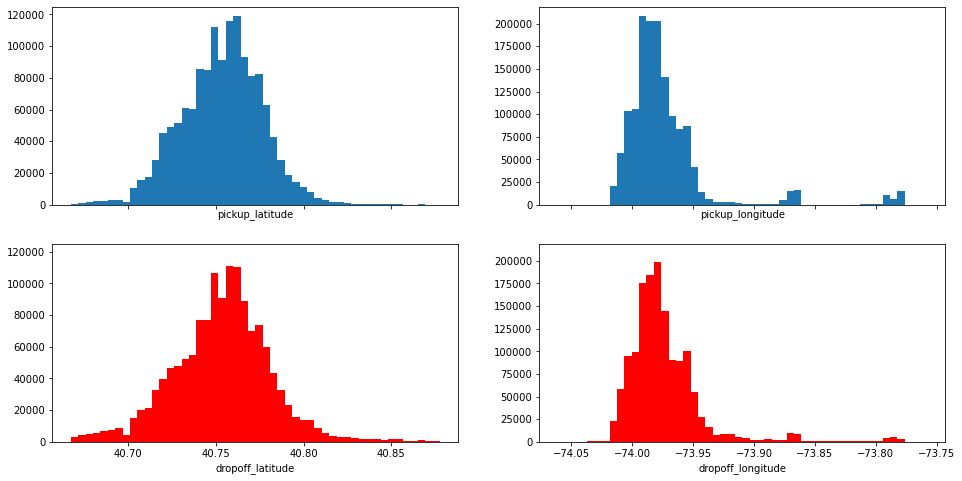

In [236]:
fig, axs = plt.subplots(2, 2, sharex='col', sharey='col', figsize=(16,8))
fig.figsize = (16, 8)
axs[0, 0].hist(taxi_df['pickup_latitude'], range=(40.66739548, 40.87765215), bins=50)
axs[0, 1].hist(taxi_df['pickup_longitude'], range=(-74.06106198, -73.7580731), bins=50)
axs[1, 0].hist(taxi_df['dropoff_latitude'], range=(40.66739548, 40.87765215), bins=50, color='red')
axs[1, 1].hist(taxi_df['dropoff_longitude'], range=(-74.06106198, -73.7580731), bins=50, color='red')
axs[0, 0].set_xlabel('pickup_latitude')
axs[0, 1].set_xlabel('pickup_longitude')
axs[1, 0].set_xlabel('dropoff_latitude')
axs[1, 1].set_xlabel('dropoff_longitude')

Ta thấy đa số các chuyến tập trung tại một khu vực, được xe như trung tâm. Trên thực tế đây là quận Manhattan. Tuy nhiên, trên đồ thị kinh độ, có 2 nơi cũng có số chuyến khá nhiều. Ta sẽ khám phá phần này ở phần trả lời câu hỏi.

Tiếp theo, thử xem các chuyến có điểm đón trùng với điểm trả khách.

In [208]:
zero_distance_trips = taxi_df[(taxi_df['pickup_latitude'] == taxi_df['dropoff_latitude']) & \
        (taxi_df['pickup_longitude'] == taxi_df['dropoff_longitude'])]
zero_distance_trips.shape[0]

5885

Xem *trip_duration* của các chuyến này

(array([2213.,  981.,  827.,  599.,  433.,  248.,  207.,  121.,   71.,
          53.]),
 array([1.0000e+00, 2.0090e+02, 4.0080e+02, 6.0070e+02, 8.0060e+02,
        1.0005e+03, 1.2004e+03, 1.4003e+03, 1.6002e+03, 1.8001e+03,
        2.0000e+03]),
 <BarContainer object of 10 artists>)

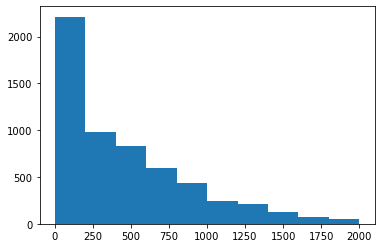

In [218]:
plt.hist(zero_distance_trips['trip_duration'], range=(1, 2000))

Có hơn 27% các chuyến không di chuyển có thời gian dưới 1 phút. Điều này có vẻ hợp lý vì hành khách lên xe khi xe chưa chạy thì đổi ý hoặc tài xế đứng đợi nhưng hủy chuyến. Ta sẽ bỏ các chuyến không di chuyển mà có duration lớn hơn 1 phút, và giữ lại các chuyến khoảng cách là 0 và nhỏ hơn một phút. Ta không nên xóa hết các chuyến không di chuyển này, có thể trong tập test sẽ có các chuyến tương tự như thế (vì trong tập test ta được cung cấp điểm đón và trả khách).

## Tiền xử lý (tiếp theo)

In [185]:
#Xóa các chuyến có passenger_count = 0, 7, 8, 9
taxi_df.drop(taxi_df[taxi_df['passenger_count'].isin([0, 7, 8, 9])].index, inplace = True)

In [186]:
#Xóa các chuyến có thời gian lớn hơn 81360s
taxi_df.drop(taxi_df[taxi_df['trip_duration'] > 81360].index, inplace = True)